# Import Modules

In [2]:
import pickle
import os

import pandas as pd
import numpy as np
from scipy import stats
from sklearn import metrics
from sklearn import model_selection
from gpmodel import gpmodel, gpkernel, chimera_tools

# Import Data

In [3]:
activations = pd.read_csv('../data/activations.csv', index_col=0)
activations.head()

,501030,501036,501038,501045,501052,501054,501079,501083,501088,501094,...,900196,900197,900199,900327,900331,900333,900334,900335,900336,900338
0,0.0380,0.0280,0.0000,0.0015,0.0320,0.0265,0.0875,0.0840,0.0245,0.0525,...,0.0180,0.010,0.0220,0.6505,0.0280,0.002,0.4165,0.005,0.011,0.0435
1,0.0000,0.0190,0.0000,0.0000,0.0335,0.1410,0.0705,0.0880,0.0285,0.0515,...,0.0055,0.002,0.0255,0.0480,0.0155,0.082,0.0625,0.000,0.000,0.0390
2,0.0420,0.0250,0.0026,0.0180,0.0945,0.1760,0.0920,0.4925,0.0465,0.0525,...,0.0000,0.000,0.2520,0.1435,0.2865,0.000,0.0000,0.000,0.000,0.0000
3,0.0335,0.0155,0.0000,0.0000,0.0705,0.4235,0.0515,0.1090,0.0570,0.0925,...,0.0000,0.208,0.5300,0.0105,0.5450,0.000,0.0690,0.000,0.000,0.0015
4,0.0000,0.0170,0.0039,0.0086,0.0195,0.1285,0.1025,0.0000,0.0000,0.0000,...,0.0315,0.000,0.1480,0.0430,0.1065,0.000,0.0000,0.000,0.000,0.0160


In [4]:
with open('../data/EFI_ID_List.p', 'rb') as EFI:
    EFIs = pd.Series(map(str, pickle.load(EFI)))
    
with open('../data/metabolite_dict.p', 'rb') as metabolite:
    metabolite_dict = pickle.load(metabolite)
renaming_dict = dict(zip(range(len(metabolite_dict)), metabolite_dict.values()))

with open('../data/Protein_seq_dict.p', 'rb') as Protein_seq:
    Protein_seq_dict = pickle.load(Protein_seq)

# Format and Process Data

In [5]:
def select_X_and_Y(df, x_rows, y_column):
    """
    Select the given X rows and Y column
    """
    # filter out empty columns
    not_dropped = ~pd.isnull(df[y_column])
    not_dropped = pd.Series(not_dropped, index=df.index)
    Ys = df[not_dropped].loc[x_rows, y_column]
    return x_rows, Ys


def process_data(df, threshold=0, transpose=False, renaming=None):
    """
    Convert numerical absorbance data into categorical data
    (active=1, inactive=-1)
    """
    formatted = df > threshold
    if renaming:
        formatted = formatted.rename(renaming)
    if transpose:
        return formatted.transpose() * 2 - 1
    return formatted * 2 - 1

# Modified Implementation for Encoding AA Seqs

In [6]:
# TODO: check encoding implementation in original paper (gpmodel.py?)
def one_hot_seq_2(seq_input):
    """
    Obsolete: use encoding_tools.one_hot_seq and np.reshape instead
    """
    # make amino acid directory
    my_dict = {'-':0, 'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,\
                'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,\
                'V':18,'W':19,'Y':20}
    L = len(seq_input[0])
    n = len(seq_input)
    
    X = np.zeros(n)
    
    for i, seq in enumerate(seq_input):
        for j, aa in enumerate(seq):
            aa_index = my_dict[aa]
            X[i] = aa_index
    return X

In [7]:
import encoding_tools

# Fit and Test using SVM
Use the SVM implementation from sklearn (rbf kernel assuming data is not linearly separable).

In [111]:
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report
from pandas import DataFrame
from sklearn.utils.fixes import loguniform
import matplotlib.pyplot as plt

def prepare_train_test(metabolite_name, threshold=0):
    """
    Format the data and return the training set and testing set.
    """
    df = process_data(activations, threshold=threshold, transpose=True, renaming=renaming_dict)
    xs, ys = select_X_and_Y(df, EFIs, metabolite_name)
    
    max_len = len(max(Protein_seq_dict.values(), key=len))
    fillchar = '-' # This is whats used in the GP-UCB paper
    Padded_dict = {}
    OH_dict = {}
    for ID in EFIs:
        Padded_dict[ID] = Protein_seq_dict[int(ID)].upper().ljust(max_len, fillchar)
        OH_dict[ID] = encoding_tools.one_hot_seq(seq_input=Padded_dict[ID])

    mapped_xs = xs.map(OH_dict)
    for i, x in enumerate(mapped_xs):
        mapped_xs[i] = x.reshape(len(x)*21)
        
    X = list(mapped_xs)
    y = ys

    return train_test_split(X, y, test_size=0.2)

def svm_gridsearch(metabolite_name, threshold=0):
    """
    Perform a GridSearchCV to tune the hyperparameters.
    """
    X_train, X_test, y_train, y_test = prepare_train_test(metabolite_name, threshold=0)
    
    param_grid = {'C': np.linspace(0.1, 1000, 10), 
              'gamma': np.linspace(0.0001, 1, 10),
              'kernel': ['rbf']} 
  
    grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 1)
    grid.fit(X_train, y_train)
    
    return grid

def svm_randomsearch(metabolite_name, X_train, y_train, threshold=0):
    """
    Perform a RandomizedSearchCV to tune the hyperparameters.
    """
    param_dist = {'C': stats.uniform(0.1, 1000),
                  'gamma': stats.uniform(0.0001, 1),
                  'kernel': ['rbf']}
    random_search = RandomizedSearchCV(svm.SVC(), param_distributions=param_dist)
    random_search.fit(X_train, y_train)
    
    return random_search

def svm_train_test(metabolite_name, threshold=0):
    """
    Run the SVM classifier and report the metrics.
    """
    X_train, X_test, y_train, y_test = prepare_train_test(metabolite_name, threshold=0)
    clf = svm_randomsearch(metabolite_name, X_train, y_train)
    result = clf.predict(X_test)
    
    print('Optimal hyperparameter for: {}, method: SVM, tuned using: {}'.format(metabolite_name, type(clf).__name__))
    print('    ', clf.best_estimator_)
    print('Confusion matrix for: {}, method: SVM'.format(metabolite_name))
    plot_confusion_matrix(clf, X_test, y_test)
    plt.show()
    #print('Classification report for: {}, method: SVM'.format(metabolite_name))
    #print(classification_report(y_test, result))

Optimal hyperparameter for: Blank, method: SVM, tuned using: RandomizedSearchCV
     SVC(C=29.297527344856146, gamma=0.7070701505038366)
Confusion matrix for: Blank, method: SVM


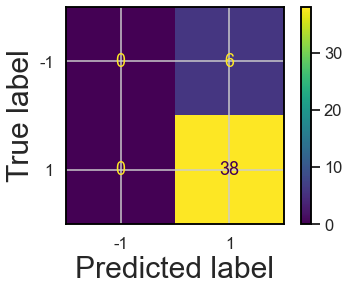


Optimal hyperparameter for: phosphoenolpyruvate, method: SVM, tuned using: RandomizedSearchCV
     SVC(C=620.2400772959434, gamma=0.5557220213889456)
Confusion matrix for: phosphoenolpyruvate, method: SVM


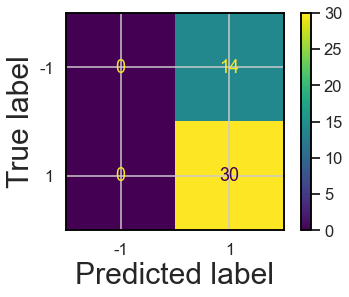


Optimal hyperparameter for: Glycerol-2-phospate, method: SVM, tuned using: RandomizedSearchCV
     SVC(C=90.07536096006575, gamma=0.2028270707128932)
Confusion matrix for: Glycerol-2-phospate, method: SVM


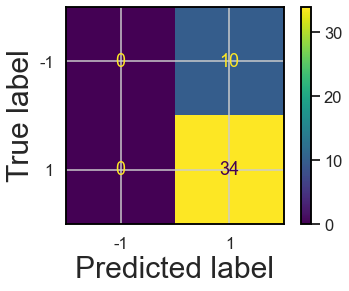


Optimal hyperparameter for: Glycerol-3-phosphate, method: SVM, tuned using: RandomizedSearchCV
     SVC(C=733.4933437774329, gamma=0.8474371865210285)
Confusion matrix for: Glycerol-3-phosphate, method: SVM


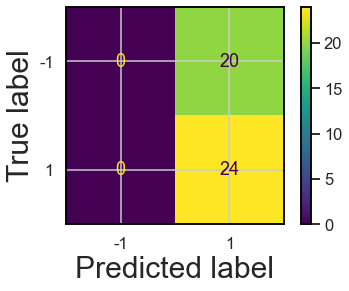


Optimal hyperparameter for: D-erythronate-4-phosphate, method: SVM, tuned using: RandomizedSearchCV
     SVC(C=400.97673867636746, gamma=0.1732701752830501)
Confusion matrix for: D-erythronate-4-phosphate, method: SVM


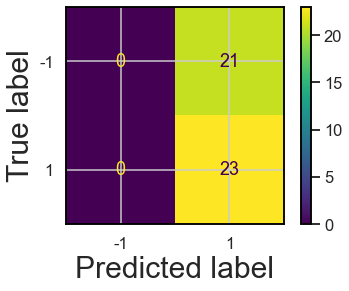

In [112]:
for metabolite in list(metabolite_dict.values())[:5]:
    svm_train_test(metabolite)
    print()

# Fit and Test using GP
Use a slightly modified version of the implementation from the original paper.

In [115]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sn

def gp_train_test(metabolite_name, threshold=0):
    df = process_data(activations, threshold=threshold, transpose=True, renaming=renaming_dict)
    xs, ys = select_X_and_Y(df, EFIs, metabolite_name)
    
    max_len = len(max(Protein_seq_dict.values(), key=len))
    fillchar = '-' # This is whats used in the GP-UCB paper
    Padded_dict = {}
    OH_dict = {}
    for ID in EFIs:
        Padded_dict[ID] = Protein_seq_dict[int(ID)].upper().ljust(max_len, fillchar)
        OH_dict[ID] = encoding_tools.one_hot_seq(seq_input=Padded_dict[ID])
        
    mapped_xs = xs.map(OH_dict)
    for i, x in enumerate(mapped_xs):
        mapped_xs[i] = x.reshape(len(x)*21)

    X = list(mapped_xs)
    y = ys

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    k = gpkernel.MaternKernel('5/2')
    clf = gpmodel.GPClassifier(k)

    clf.fit(X_train, y_train)
    f_bar = clf.predict(X_test)[1]
    
    # GPML Chapter 3, Algorithm 3.2
    # f_bar = dot(k*, grad)
    # For positive sample, f_bar > 0; for negative sample, f_bar < 0 
    # because grad > 0 for positive sample and < 0 otherwise (Section 3.4.2)
    result = (f_bar > 0) * 2 - 1
    
    print('Confusion matrix for: {}, method: GP'.format(metabolite_name))
    cm = confusion_matrix(y_test, result)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #df_cm = pd.DataFrame(cm)
    #heatmap = sn.heatmap(df_cm, annot=True, cmap='viridis')
    disp.plot()
    plt.show()

Confusion matrix for: Blank, method: GP


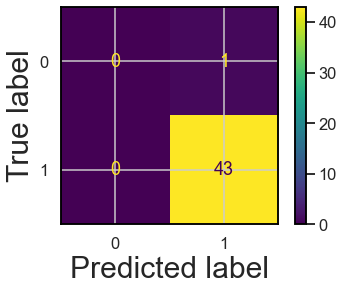

Confusion matrix for: phosphoenolpyruvate, method: GP


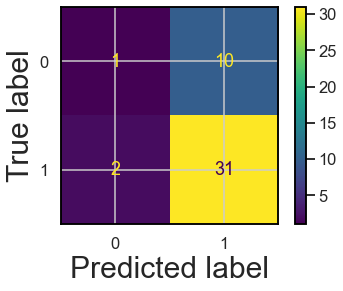

Confusion matrix for: Glycerol-2-phospate, method: GP


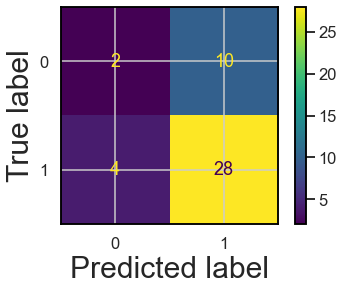

Confusion matrix for: Glycerol-3-phosphate, method: GP


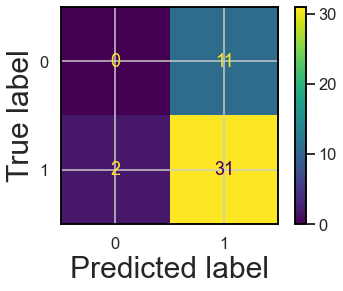

Confusion matrix for: D-erythronate-4-phosphate, method: GP


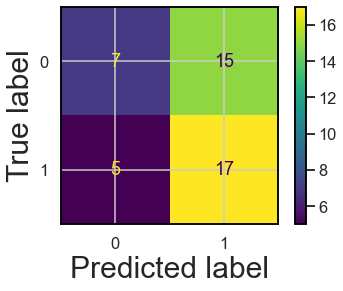

Confusion matrix for: L-erythronate-4-phosphate, method: GP


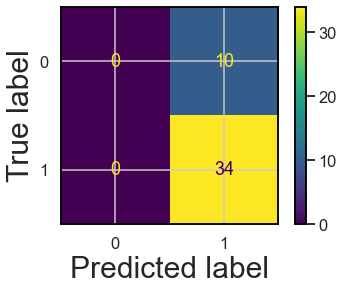

Confusion matrix for: D-threonate-4-phosphate, method: GP


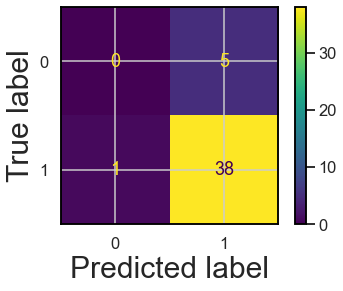

Confusion matrix for: Pyrophosphate, method: GP


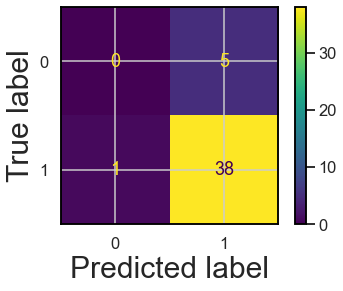

Confusion matrix for: ATP, method: GP


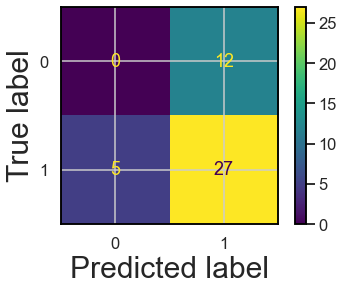

Confusion matrix for: TTP, method: GP


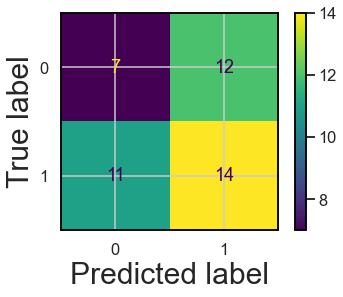

In [116]:
for metabolite in list(metabolite_dict.values())[:10]:
    gp_train_test(metabolite)

# SVM with t-SNE Clustering
Using sklearn. Did not observe any substantial clustering (?)

In [ ]:
from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import matplotlib.pyplot as plt

def svm_tsne_train_test(metabolite_name, threshold=0):
    df = process_data(activations, threshold=threshold, transpose=True, renaming=renaming_dict)
    xs, ys = select_X_and_Y(df, EFIs, metabolite_name)

    max_len = len(max(Protein_seq_dict.values(), key=len))
    fillchar = '-' # This is whats used in the GP-UCB paper
    Padded_dict = {}
    OH_dict = {}
    for ID in EFIs:
        Padded_dict[ID] = Protein_seq_dict[int(ID)].upper().ljust(max_len, fillchar)
        OH_dict[ID] = encoding_tools.one_hot_seq(seq_input=Padded_dict[ID])
        
    mapped_xs = xs.map(OH_dict)
    for i, x in enumerate(mapped_xs):
        mapped_xs[i] = x.reshape(len(x)*21)
        
    X = list(mapped_xs)
    y = ys
    
    tsne = TSNE(n_components=2, 
            perplexity=20,
            learning_rate=340)
    X_embedded = tsne.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_embedded, y, test_size=0.2)
    clf = svm.SVC(kernel='rbf')

    clf.fit(X_train, y_train)
    result = clf.predict(X_test)
    
    print('Confusion matrix for: {}, method: SVM with t-SNE'.format(metabolite_name))
    plot_confusion_matrix(clf, X_test, y_test)
    plt.show()

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)

tsne = TSNE(n_components=2, 
            method='exact',
            perplexity=20,
            learning_rate=340)
X_embedded = tsne.fit_transform(X)

fig = plt.figure(figsize=(6,6))
#ax = Axes3D(fig)
plt.scatter(x=X_embedded[:,0], y=X_embedded[:,1], c=y, cmap=plt.cm.coolwarm)

In [ ]:
for metabolite in list(metabolite_dict.values())[:10]:
    svm_tsne_train_test(metabolite)

# Fit and Test using Decision Tree

# Fit and Test using Random Forest